## WET-001 Analysis

To be able to run this notebook, you will need to have set up the environment and will need access to `ts_ofc` and `ts_imsim`. 

Additionally, you will need access to the butler where your images and collections are stored. For now, with simulated data, 
that means access to usdf corresponding folder.

Relevant imports

In [58]:
import numpy as np
import os
from astropy.io import fits
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

from lsst.ts.ofc import StateEstimator, OFCData
import analysis_functions as analysis

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Set the butler root path

In [4]:
# Set the butler root path that will be used to access the relevant ingested images
butler_root_path = '/sdf/data/rubin/u/gmegias/projects/commissioning_sims/butler_wet001'
# Set butler instrument name     
butler_inst_name = 'Cam'

### Load Wavefront Estimates

In [62]:
# Retrieve the zernike estimates for 100 optical states.
wfe_array = np.zeros((99, 4, 19))
for idx, state in tqdm(enumerate(np.arange(1,100)), total = 99):

    # Set collection name
    seq_num = 2000 + state
    collection_name = f"dof_refit_{seq_num}"

    # Retrieve wavefront estimates and store them
    list_of_wf_err = analysis.compute_zernike_estimates(
        collection_name,
        butler_root_path,
        butler_inst_name
    )
    sorted_list_of_wf_err = sorted(list_of_wf_err, key=lambda sensor_wfe: sensor_wfe.sensor_name)

    sensor_names = np.array(
        [sensor_wfe.sensor_name for sensor_wfe in sorted_list_of_wf_err]
    )

    wfe = np.array(
        [sensor_wfe.annular_zernike_poly for sensor_wfe in sorted_list_of_wf_err]
    )

    wfe_array[idx, :, :] = wfe

  0%|          | 0/99 [00:00<?, ?it/s]

### Comparison to true Zernikes

This step can't be done with real data.
Load true opd data from the repository where the simulated images are stored. 

In [63]:
opd_array = np.zeros((99, 4, 19))

for idx, state in tqdm(enumerate(np.arange(1,100)), total = 99):
    path = f'/sdf/data/rubin/u/gmegias/projects/commissioning_sims/WET-001_lsstcam/state_{state}/opd.fits'
    opd_array[idx, :, :] = analysis._map_opd_to_zk(path, 0, 4)

  0%|          | 0/99 [00:00<?, ?it/s]

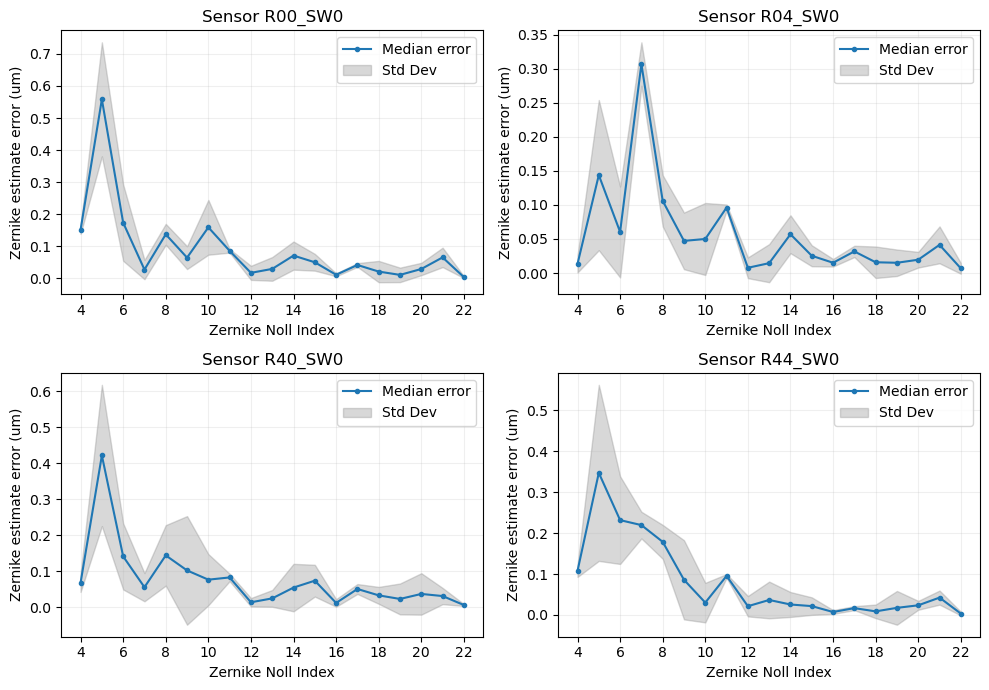

In [64]:
zernikes_error = np.abs(wfe_array - opd_array)

# Because some avg values are nan, we will remove them.
# This behavior where ts_wep gives a correct zernike estimate for each cutout donut
# but returns nan for the average is currently being investigated. 
# For now, this doesn't stop us from our analysis 
# find where zernikes_error is nan 
nan_idx = np.unique(np.where(np.isnan(wfe_array))[0])
zernikes_error = np.delete(zernikes_error, nan_idx, axis = 0)

# Compute median and std error
median_error = np.median(zernikes_error, axis = 0)
std_error = np.std(zernikes_error, axis = 0)

upper_bound = median_error + std_error
lower_bound = median_error - std_error

plt.figure(figsize = (10,7))
for idx in range(4):
    plt.subplot(2,2,idx + 1)
    # Plot the median error
    plt.plot(np.arange(4, 23), median_error[idx, :], '.-', label='Median error')

    # Fill between upper and lower bounds with gray transparency
    plt.fill_between(np.arange(4, 23), lower_bound[idx, :], upper_bound[idx, :], color='gray', alpha=0.3, label='Std Dev')

    # Add labels and legend
    plt.xticks(np.arange(4,23,2))
    plt.xlabel('Zernike Noll Index')
    plt.ylabel('Zernike estimate error (um)')
    plt.title(f'Sensor {sensor_names[idx]}')
    plt.legend()    
    plt.grid(alpha = 0.2)

plt.tight_layout()

Plot zernike estimate comparison between two states

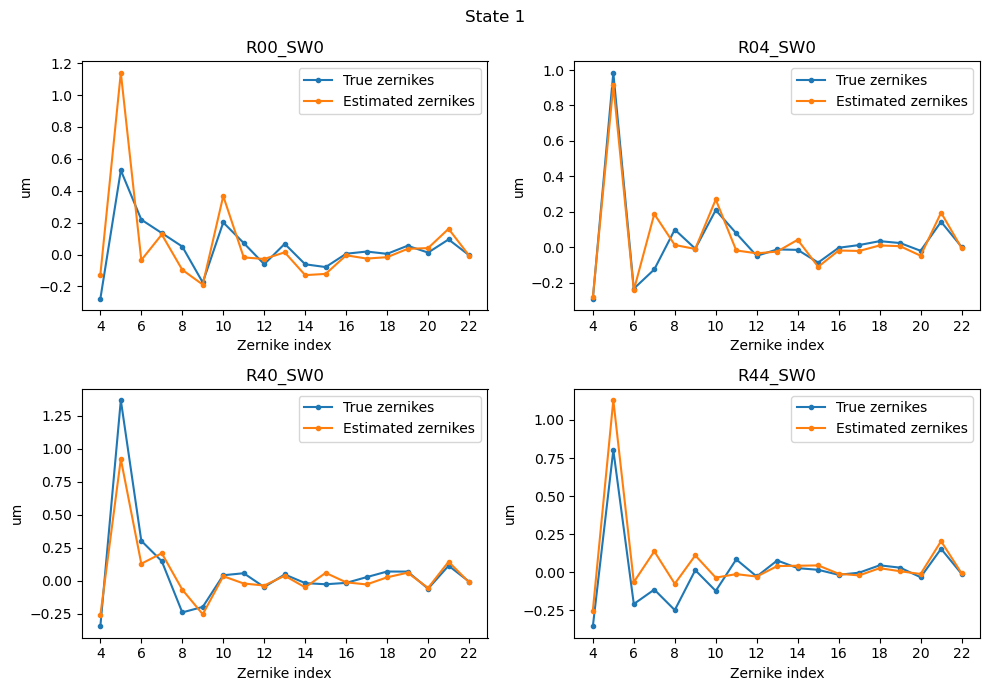

In [65]:
plt.figure(figsize = (10,7))

id_state = 1
for idx in range(4):
    plt.subplot(2,2,idx + 1)
    plt.plot(np.arange(4,23), opd_array[id_state, idx, :], '.-', label = 'True zernikes')
    plt.plot(np.arange(4,23), wfe_array[id_state, idx, :], '.-', label = 'Estimated zernikes')
    plt.title(sensor_names[idx])
    plt.xticks(np.arange(4,23,2))
    plt.xlabel('Zernike index')
    plt.ylabel('um')
    plt.legend()

plt.suptitle(f'State {id_state}')
plt.tight_layout()

### Estimate Optical State and compare to true DOF

In [73]:
# This part here will need to change to the optical state used for this specific image. 
# For now, we use the set of dof_state simulated with imsim. 
# Where should this data come from?
dof_dataset = np.load('/sdf/home/g/gmegias/aos/imsim_simulations/dof_dataset_new.npy')
# select only the first 99 states
dof_dataset = dof_dataset[:99, :]

# Initialize OFCData and State Estimator. We need to decide what is the truncation rcond
ofc_data = OFCData('lsst')
state_estimator = StateEstimator(ofc_data, rcond=1e-3)

optical_states = np.zeros((99, 50))
for idx, state in tqdm(enumerate(np.arange(1,100)), total = 99):
    optical_state = state_estimator.dof_state(
        'R', wfe_array[idx, ...], sensor_names, 0.0
    )
    optical_states[idx, :] = optical_state

-------------------- False -------------------


  0%|          | 0/99 [00:00<?, ?it/s]

Compare the estimated optical state to the true DOF for one state

Text(0.5, 0.98, 'Estimated vs injected optical state for state 1')

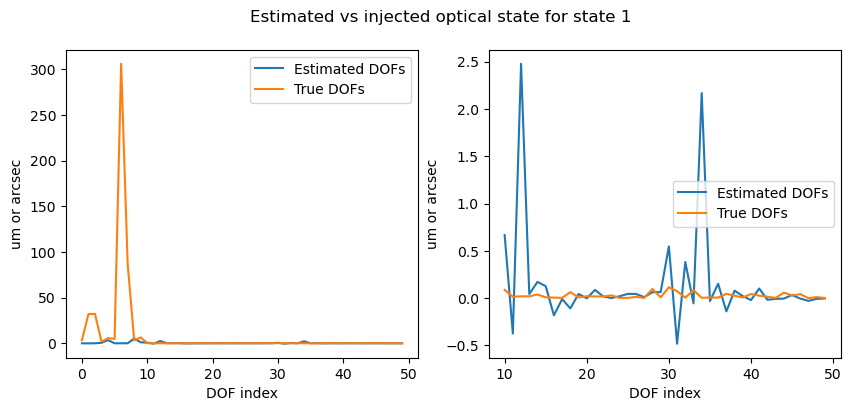

In [74]:
state_id = 1

plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.plot(optical_states[state_id, :], label = 'Estimated DOFs')
plt.plot(dof_dataset[state_id, :], label = 'True DOFs')
plt.legend()
plt.ylabel('um or arcsec')
plt.xlabel('DOF index')

plt.subplot(1,2,2)
plt.plot(np.arange(10,50), optical_states[state_id, 10:], label = 'Estimated DOFs')
plt.plot(np.arange(10,50), dof_dataset[state_id, 10:], label = 'True DOFs')
plt.legend()
plt.ylabel('um or arcsec')
plt.xlabel('DOF index')

plt.suptitle('Estimated vs injected optical state for state 1')

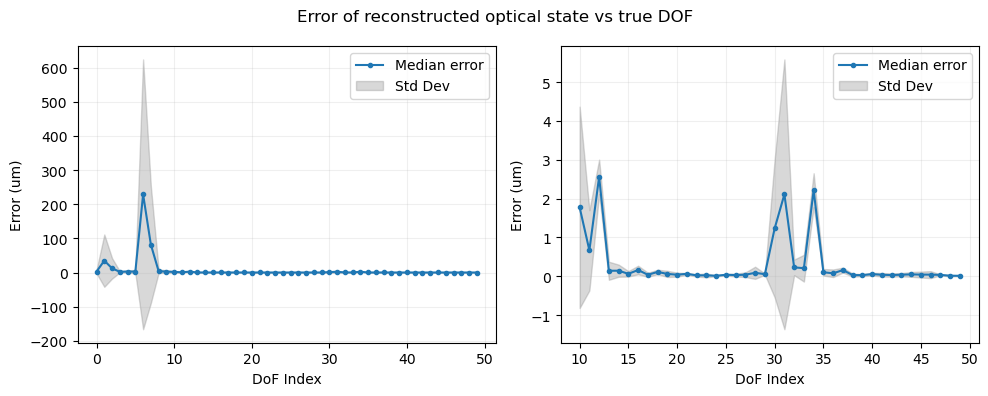

In [68]:
dofs_error = np.abs(dof_dataset - optical_states)
nan_idx = np.unique(np.where(np.isnan(wfe_array))[0])
dofs_error = np.delete(dofs_error, nan_idx, axis = 0)

median_error = np.median(dofs_error, axis = 0)
std_error = np.std(dofs_error, axis = 0)
upper_bound = median_error + std_error
lower_bound = median_error - std_error

plt.figure(figsize = (10,4))

plt.subplot(1,2,1)
# Plot the median error
plt.plot(np.arange(0,50), median_error, '.-', label='Median error')
# Fill between upper and lower bounds with gray transparency
plt.fill_between(np.arange(0, 50), lower_bound, upper_bound, color='gray', alpha=0.3, label='Std Dev')

# Add labels and legend
plt.xlabel('DoF Index')
plt.ylabel('Error (um)')
plt.legend()    
plt.grid(alpha = 0.2)


plt.subplot(1,2,2)
# Plot the median error
plt.plot(np.arange(10,50), median_error[10:], '.-', label='Median error')
# Fill between upper and lower bounds with gray transparency
plt.fill_between(np.arange(10, 50), lower_bound[10:], upper_bound[10:], color='gray', alpha=0.3, label='Std Dev')

# Add labels and legend
plt.xlabel('DoF Index')
plt.ylabel('Error (um)')
plt.legend()    
plt.grid(alpha = 0.2)

plt.suptitle('Error of reconstructed optical state vs true DOF')
plt.tight_layout()

### Compare wavefront of estimated optical state to estimated wavefront

In [69]:
sensitivity_matrix = analysis.compute_sensitivity_matrix(ofc_data, sensor_names)

# Create an empty array to store the results
zk_reconstructed_expanded = np.zeros((99, 4, 19))

# Iterate over the optical states
for idx in range(99):
    # Perform the operation for each optical state
    zk_reconstructed = sensitivity_matrix @ optical_states[idx, :]
    zk_reconstructed_expanded[idx, :, :] = zk_reconstructed.reshape(4, 19)

Plot for one state the comparison between the estimated wavefront and the wavefront obtained from the estimated optical state

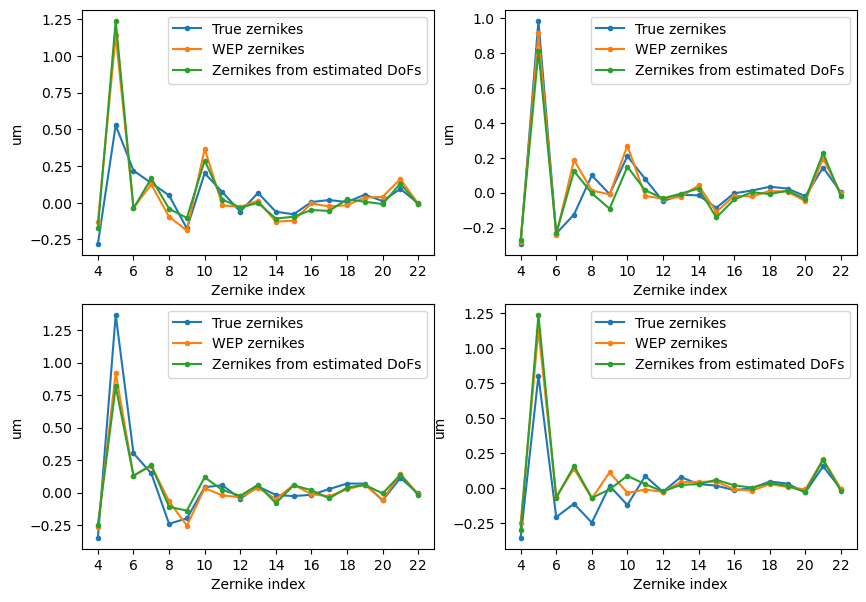

In [70]:
state_id = 1
plt.figure(figsize = (10,7))

for idx in range(4):
    plt.subplot(2,2,idx + 1)
    plt.plot(np.arange(4,23), opd_array[state_id, idx, :], '.-', label = 'True zernikes')
    plt.plot(np.arange(4,23), wfe_array[state_id, idx, :], '.-', label = 'WEP zernikes')
    plt.plot(np.arange(4,23), zk_reconstructed_expanded[1, idx, :], '.-', label = 'Zernikes from estimated DoFs')
    plt.xlabel('Zernike index')
    plt.xticks(np.arange(4,23,2))
    plt.ylabel('um')
    plt.legend()

Statistics of reconstructed zernikes compared to the zernikes estimated by ts_wep.

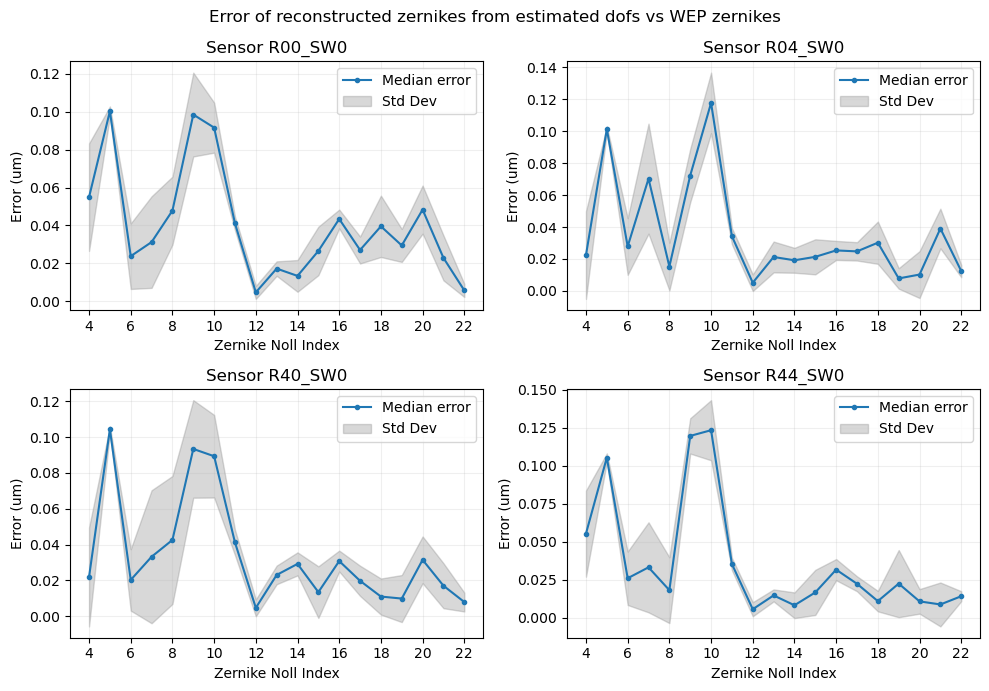

In [71]:
zernikes_error = np.abs(wfe_array - zk_reconstructed_expanded)

# Because some avg values are nan, we will remove them.
# This behavior where ts_wep gives a correct zernike estimate for each cutout donut
# but returns nan for the average is currently being investigated. 
# For now, this doesn't stop us from our analysis 
# find where zernikes_error is nan 
nan_idx = np.unique(np.where(np.isnan(wfe_array))[0])
zernikes_error = np.delete(zernikes_error, nan_idx, axis = 0)

median_error = np.median(zernikes_error, axis = 0)
std_error = np.std(zernikes_error, axis = 0)
upper_bound = median_error + std_error
lower_bound = median_error - std_error

plt.figure(figsize = (10,7))
for idx in range(4):
    plt.subplot(2,2,idx + 1)
    # Plot the median error
    plt.plot(np.arange(4, 23), median_error[idx, :], '.-', label='Median error')

    # Fill between upper and lower bounds with gray transparency
    plt.fill_between(np.arange(4, 23), lower_bound[idx, :], upper_bound[idx, :], color='gray', alpha=0.3, label='Std Dev')

    # Add labels and legend
    plt.xticks(np.arange(4,23,2))
    plt.xlabel('Zernike Noll Index')
    plt.ylabel('Error (um)')
    plt.title(f'Sensor {sensor_names[idx]}')
    plt.legend()    
    plt.grid(alpha = 0.2)

plt.suptitle('Error of reconstructed zernikes from estimated dofs vs WEP zernikes')
plt.tight_layout()